In [14]:
"""
If you run this block more than once you will get 88 THOUSAND newlines (in the data)
"""

import json
import numpy as np
import pandas
import matplotlib.pyplot as plt

#this code makes your editing experience using both python files 
#and notebooks a lot easier
%load_ext autoreload
#written to make things easier
%aimport utility 
%autoreload 1

#this is done to avoid the double processing problem
origin_sjc, origin_state_appeals = utility.combine_cases()
all_sjc = origin_sjc.copy(deep=True)
all_state_appeals = origin_state_appeals.copy(deep=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#returns case numbers and sections in which found within a case
def find_in_text(case_data,phrase):
    cases_found = []
    for case in range(len(case_data)):
        place_found = []
        for i in range(len(case_data[case]["text"])):
            if case_data[case]["text"][i].lower().find(phrase.lower()) != -1:
                place_found.append(i)
        
        if len(place_found) > 0:
            cases_found.append([case,place_found])
    return cases_found

In [16]:
def find_in_headnote(case_data,phrase):
    cases_found = []
    for case in range(len(case_data)):
        place_found = []
        for i in range(len(case_data[case]["headnote"])):
            if case_data[case]["headnote"][i].lower().find(phrase.lower()) != -1:
                place_found.append(i)
        
        if len(place_found) > 0:
            cases_found.append([case,place_found])
    return cases_found

In [17]:
# Searches list_of_keywords in string case_data
# and returns the total number of cases that contained any keyword
#as well as the "case numbers", that is, currently
#line numbers in the file
def number_of_cases_per_keywords(case_data, list_of_keywords):
    all_cases = set()
    for keyword in list_of_keywords:
        all_with_keyword = set()
        all_in_text = find_in_text(case_data, keyword)
        all_in_headnote = find_in_headnote(case_data, keyword)
        for occurence in all_in_text:
            all_with_keyword.add(occurence[0])
        for occurence in all_in_headnote:
            all_with_keyword.add(occurence[0])
        all_cases.update(all_with_keyword)
    pretty = list(all_cases)
    pretty.sort()
    return len(pretty), pretty

In [18]:
def contains(dataframe, *keywords):
    logical_list = dataframe.text.str.contains(keywords[0])
    for i in range(1, len(keywords)):
        logical_list = logical_list | dataframe.text.str.contains(keywords[i])
    return logical_list

#elementwise xor:
#returns true at i if and only if series1[i] and series2[i]
#are different
def logic_xor(series1, series2):
    return (series1 | series2) & ~(series1 & series2)


In [19]:
important_keywords = ["confidential informant", " ci ", "snitch", "informant", "gang informant"]

In [20]:
#we used to have a duplicate row problem


# print("statistics of how we are double counting: values represent how many times an index appears")
# print(all_sjc.index.to_series().value_counts().describe(), "\n\n")

# print("showing you in the other list, max is like half of the whole list (statistics a)")
# print(all_state_appeals.index.to_series().describe(), "\n")

# print("statistics of how bad the problem is in that list")
# print(all_state_appeals.index.to_series().value_counts().describe(), "\n\n")

# print("thus, if you sort things, it looks like this")
# print(all_state_appeals.sort_index()[0:6], "\n")

# print("this leads to the following problem:")


# """
# print("You see this makes things much more reasonable to remove \
# newlines but it also squishes punctuation sometimes:\n")
# print(messed_up.str.replace(pat="\n", repl="").iloc[0][0:500], "...\n")

# print("This is a big problem in the state appeals cases. Statistics for newlines in state appeals:\n",
#       all_state_appeals.text.str.count("\n").describe())

# print("\nNote: there are no newlines in sjc cases: \n", all_sjc.text.str.count("\n").describe(), "\n")

# #so, replace the text column to have it be good
# all_state_appeals.text = all_state_appeals.text.str.replace(pat="\n", repl="")
# """


In [21]:
#Check that some files are ok
#There also used to be a big problem here with newlines

print("An sjc case partial text:")
print(all_sjc.loc[ 0, : ].text[0:300], "...\n\n")

print("A state appeals partial text:")
messed_up = all_state_appeals[1:2].text
print(messed_up.values[0][0:300], "...\n\n")



An sjc case partial text:


T
h
e
 
p
r
e
s
e
n
t
 
c
a
s
e
 
i
s
 
t
h
e
 
m
o
s
t
 
r
e
c
e
n
t
 
i
n
 
a
 
s
e
r
i
e
s
 
o
f
 
c
a
s
e
s
 
c
o
n
c
e
r
n
i
n
g
 
t
h
e
 
e
g
r
e
g
i
o
u
s
 
m
i
s
c
o
n
d
u
c
t
 
o
f
 
A
n
n
i
e
 
D
o
o
k
h
a
n
,
 
a
 
c
h
e
m
i
s
t
 
w
h
o
 
w
a
s
 
e
m
p
l
o
y
e
d
 
i
n
 
t
h
e
 
f
o
r
e
 ...


A state appeals partial text:


T
h
i
s
 
c
a
s
e
 
a
r
i
s
e
s
 
f
r
o
m
 
t
h
e
 
g
r
a
n
t
 
o
f
 
a
 
g
r
o
u
n
d
w
a
t
e
r
 
d
i
s
c
h
a
r
g
e
 
p
e
r
m
i
t
 
(
p
e
r
m
i
t
)
 
t
o
 
t
h
e
 
t
o
w
n
 
o
f
 
F
a
l
m
o
u
t
h
 
(
t
o
w
n
)
 
f
o
r
 
t
h
e
 
c
o
n
s
t
r
u
c
t
i
o
n
 
a
n
d
 
o
p
e
r
a
t
i
o
n
 
o
f
 
a
 
w
a
s
 ...




In [22]:
vacate_indeces = all_sjc.text.str.contains("vacate") | contains(all_sjc,"vacated")


we_affirm = contains(all_sjc, "We affirm", "we affirm")
print("we affirm\n", we_affirm.value_counts())

affirmed_indeces = all_sjc.text.str.contains("affirm") | we_affirm
print("all Affirmed cases:\n", affirmed_indeces.value_counts())


we_reverse = contains(all_sjc, "we reverse") | contains(all_sjc, "We reverse")
print("\nwe reverse\n", we_reverse.value_counts())

reversed_indeces = all_sjc.text.str.contains("reverse") | we_reverse
print("\nall w reversed:\n", reversed_indeces.value_counts())


really_bad = we_affirm & we_reverse

print("\nhas both we affirm and we reverse\n", really_bad.value_counts())

both_reversed_and_affirmed = reversed_indeces & affirmed_indeces
print("\nreversed and affirmed\n", both_reversed_and_affirmed.value_counts())
print(both_reversed_and_affirmed.sort_values())
#print(all_sjc.loc[ 681, : ].text)

print("\nonly one or the other appears:")
print(logic_xor(reversed_indeces, affirmed_indeces).value_counts())

we affirm
 False    1779
True      876
Name: text, dtype: int64
all Affirmed cases:
 True     1489
False    1166
Name: text, dtype: int64

we reverse
 False    2513
True      142
Name: text, dtype: int64

all w reversed:
 False    2125
True      530
Name: text, dtype: int64

has both we affirm and we reverse
 False    2613
True       42
Name: text, dtype: int64

reversed and affirmed
 False    2241
True      414
Name: text, dtype: int64
0       False
1673    False
1674    False
1675    False
1677    False
        ...  
1825     True
1827     True
1834     True
674      True
1327     True
Name: text, Length: 2655, dtype: bool

only one or the other appears:
False    1464
True     1191
Name: text, dtype: int64


In [23]:
terrible_cases = ~(contains(all_sjc,
    "reverse", "affirm", "vacate", "uphold", "overturn", "disagree", "defer",
                            "reject", "remand", "Appeal dismissed"))
print("Terrible cases we can't deal with, have no keywords:\n", 
         terrible_cases.value_counts(), "\n")

terrible_cases = terrible_cases.sort_values()
print("Classification of some of the cases:\n", terrible_cases,"\n")

print("For example:")
print(all_sjc.loc[ 2500, : ].text, "...\n\n")
    

Terrible cases we can't deal with, have no keywords:
 False    1843
True      812
Name: text, dtype: int64 

Classification of some of the cases:
 1327    False
1668    False
1669    False
1670    False
1671    False
        ...  
395      True
394      True
393      True
402      True
0        True
Name: text, Length: 2655, dtype: bool 

For example:
INDICTMENTS found and returned in the Superior Court Department on November 2, 2010.
Pretrial motions to suppress evidence were heard by Charles J. Hely, J., and Janet L. Sanders, J., and cases were tried before Linda E. Giles, J.
Jeffrey L. Baler for Alexander Gallett.
Andrew S. Crouch for Michel St. Jean.
Sarah Montgomery Lewis, Assistant District Attorney (Jennifer Hickman, Assistant District Attorney, also present) for the Commonwealth. ...




In [24]:
copy = all_sjc.copy(deep=True)

def add_counts(dataframe, word_list):
    for word in word_list:
        col_name = word+ " count"
        dataframe[col_name] = dataframe.text.str.count(word)
        
        
triggers = ["We affirm", "we affirm", "We reverse", 
            "we reverse", "vacate", "affirm", "reverse", "Appeal dismissed"]
add_counts(copy, triggers)

print(copy)
    
# print(copy["Appeal dismissed count"].value_counts())

                                                   case  \
0       C O M M O N W E A L T H     v s .     A D M ...   
1       C O M M O N W E A L T H     v s .     G E O ...   
2       L I N D A   S .   B O W E R S     v s .     ...   
3       C O M M O N W E A L T H     v s .     J A R ...   
4       C O M M O N W E A L T H     v s .     R O B ...   
...                                                 ...   
2650                      IN THE MATTER OF CLAUDE DAVID   
2651                             KAROL E. SIMONTON, pet   
2652                                              A.F.    
2653                      IN THE MATTER OF CARL MARTIN    
2654               BHARANIDHARAN PADMANABHAN vs. LORETT   

                                               headnote  \
0     C\no\nn\nt\nr\no\nl\nl\ne\nd\n \nS\nu\nb\ns\nt...   
1     H\no\nm\ni\nc\ni\nd\ne\n.\n \nE\nv\ni\nd\ne\nn...   
2     N\ne\ng\nl\ni\ng\ne\nn\nc\ne\n,\n \nR\ne\nt\na...   
3     C\no\nn\ns\nt\ni\nt\nu\nt\ni\no\nn\na\nl\n \nL...

In [25]:

#need to look at vacate
def add_status(dataframe):
    
    
    #creating the column
    triggers = ["We affirm", "we affirm", "We reverse", 
            "we reverse", "vacate", "affirm", "reverse", "Appeal dismissed"]
    add_counts(dataframe, triggers)
    dataframe["decision"] = "undecided"
    
    definite_affirm = contains(dataframe, "We affirm", "we affirm")
    definite_reverse = contains(dataframe, "We reverse", "we reverse")
    
    dataframe.decision[definite_reverse] = "reverse"
    dataframe.decision[definite_affirm] = "affirm"
    
    print("After look for\"we\" keyword, we have the following:")
    print(dataframe.decision.value_counts())
        
    
    sort_of_affirm = (dataframe["affirm count"] > 0) & (dataframe.decision == "undecided")
    sort_of_reverse = (dataframe.decision == "undecided") & (dataframe["affirm count"] > 0)
    
    dataframe.decision[sort_of_affirm] = "affirm"
    dataframe.decision[sort_of_reverse] = "reverse"
    
    print("Adding a less strict approach we have the following:")
    print(dataframe.decision.value_counts())
    
    dismissed = (dataframe.decision == "undecided") & (dataframe["Appeal dismissed count"] > 0)
    dataframe.decision[dismissed] = "affirm"
    
    print("With dismissed:")
    print(dataframe.decision.value_counts())
    
#     dataframe.decision[sort_of_affirm] = "affirm"
#     dataframe.decision[sort_of_reverse] = "reverse"
    
#     undecided_still = dataframe.decision.str.contains("undecided")
#     print("Decision was not that conclusive couldn't find any keyword :\n"
#           , undecided_still.value_counts(), "\n")

    
    
    
add_status(copy)


After look for"we" keyword, we have the following:
undecided    1679
affirm        876
reverse       100
Name: decision, dtype: int64
Adding a less strict approach we have the following:
undecided    1120
affirm        876
reverse       659
Name: decision, dtype: int64
With dismissed:
undecided    1090
affirm        906
reverse       659
Name: decision, dtype: int64


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: Set

### Expanding on our overturned analysis we will perform a logistic regression on the data. 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: Set

After look for"we" keyword, we have the following:
undecided    1679
affirm        876
reverse       100
Name: decision, dtype: int64
Adding a less strict approach we have the following:
undecided    1120
affirm        876
reverse       659
Name: decision, dtype: int64
With dismissed:
undecided    1090
affirm        906
reverse       659
Name: decision, dtype: int64
After look for"we" keyword, we have the following:
undecided    3115
affirm        933
reverse       308
Name: decision, dtype: int64
Adding a less strict approach we have the following:
undecided    2406
reverse      1017
affirm        933
Name: decision, dtype: int64
With dismissed:
undecided    2402
reverse      1017
affirm        937
Name: decision, dtype: int64


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Before Logistic Regression')

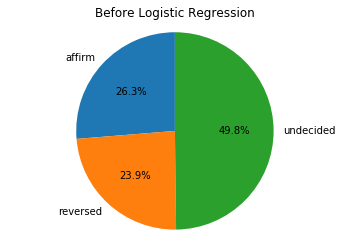

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# First we do a deep copy of both our sjc and appeals cases and assign as many decisions as we can
copy_sjc = all_sjc.copy(deep=True)
add_status(copy_sjc)
copy_appeals = all_state_appeals.copy(deep=True)
add_status(copy_appeals)

# now we separate all unlabeled data from our dataframe, all undecided cases.
all_cases = copy_sjc.append(copy_appeals)
undecided_cases = all_cases.loc[all_cases["decision"] == "undecided"]
all_cases = all_cases.loc[all_cases["decision"] != "undecided"]

# We change labels to indeces
affirm = (all_cases.decision == "affirm")
all_cases.decision[affirm] = 1
reverse = (all_cases.decision == "reverse")
all_cases.decision[reverse] = 0


# Compile all our text data.
str_txt = []
text = pd.DataFrame(all_cases["text"])
for i in range(len(text.values)):
    str_txt.append(text.values[i][0])

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english',min_df=0.001)
vectorizer = vectorizer.fit(str_txt)
words = vectorizer.get_feature_names()
matrix = vectorizer.transform(str_txt)
pd_matrix = pd.DataFrame(matrix.toarray(),columns=words)

# plot the results in a pie chart
num_affirm = all_cases.loc[all_cases["decision"] == 1]
num_reversed = all_cases.loc[all_cases["decision"] == 0]
num_undec = undecided_cases
plt.pie([len(num_affirm),len(num_reversed),len(num_undec)],labels=["affirm","reversed","undecided"],startangle=90,autopct='%1.1f%%')
plt.axis('equal')
plt.title("Before Logistic Regression")


In [27]:
print(pd_matrix)

       00  000  0000  001  002  003  005  006  007  009  ...  zotos  zucco  \
0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
1     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
2     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
4     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
...   ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
3514  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3515  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3516  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3517  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3518  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   

      zuckerman  zukoski  zullo  zuluaga  zurich  zussman  zuzi

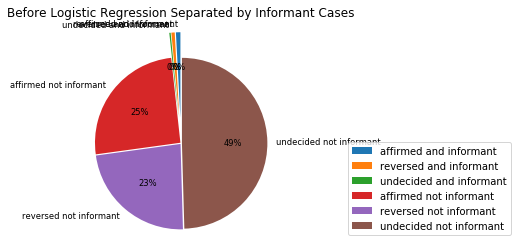

In [28]:
# Relevance to informant search in pie chart
affirm_inform = contains(num_affirm,"confidential informant", " ci ", "snitch", "informant", "gang informant")
affirm_inform = affirm_inform.loc[affirm_inform==True]
reverse_inform = contains(num_reversed,"confidential informant", " ci ", "snitch", "informant", "gang informant")
reverse_inform = reverse_inform.loc[reverse_inform==True]
undec_inform = contains(num_undec,"confidential informant", " ci ", "snitch", "informant", "gang informant")
undec_inform = undec_inform.loc[undec_inform==True]

labels=["affirmed and informant","reversed and informant","undecided and informant","affirmed not informant","reversed not informant","undecided not informant"]
plt.pie([len(affirm_inform),len(reverse_inform),len(undec_inform),len(num_affirm)-len(affirm_inform),len(num_reversed)-len(reverse_inform),len(num_undec)-len(undec_inform)],labels=labels,startangle=90,autopct="%1.0i%%",explode=(0.3, 0.3,0.3, 0.01, 0.01,0.01),textprops={'size': 'small'})
plt.axis('equal')
plt.title("Before Logistic Regression Separated by Informant Cases")
plt.legend(loc='lower right',bbox_to_anchor=(1, 0, 0.5, 1))

Text(0.5, 1.0, 'Before Logistic Regression Informant Cases and their Decisions')

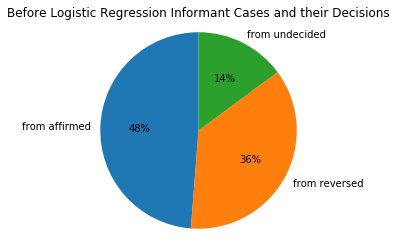

In [29]:
# now for only informant cases, what are their decisions
plt.pie([len(affirm_inform),len(reverse_inform),len(undec_inform)],labels=["from affirmed","from reversed","from undecided"],startangle=90,autopct="%1.0i%%")
plt.axis('equal')
plt.title("Before Logistic Regression Informant Cases and their Decisions")

### Now we do the logistic regression

In [30]:
# Perform Logistic Regression
logreg = LogisticRegression(verbose=1,solver="sag", n_jobs=4).fit(pd_matrix,list(all_cases["decision"]))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 34 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.7s finished


In [31]:
#logistic regression training accuracy 86%
logreg.score(pd_matrix,list(all_cases["decision"]))

0.8604717249218528

In [32]:
# Here we evaluate the relative importance of each word to the prediction of the logistic regression
# The more a word has a negative coefficient, the more important it is for the algorithm to predict it as reversed.
# The more a word has a positive coefficient, the more important it is for the algorithm to predict it as affirmed.
importance = pd.DataFrame(logreg.coef_,columns=pd_matrix.columns)
importance = pd.Series(importance.transpose()[0])
importance = importance.sort_values()
print(importance[:20])
print()
print(importance[-20:])
len(importance)


reversed         -1.472799
complainant      -1.414327
officer          -1.302026
reverse          -1.254536
remanded         -1.147904
juvenile         -0.996059
seller           -0.975601
transfer         -0.974655
proceedings      -0.954312
presentment      -0.904968
commission       -0.842687
rosenthal        -0.838797
putnam           -0.834024
search           -0.832448
preclusion       -0.816613
case             -0.815161
art              -0.805064
superintendent   -0.801138
williams         -0.790366
retrial          -0.778223
Name: 0, dtype: float64

denied        0.915876
relief        0.923439
panel         0.933112
jury          0.952913
gonzalez      0.957728
denying       0.978006
defendants    0.996226
justice       1.001130
officers      1.048127
counsel       1.085719
single        1.095953
discretion    1.111591
mass          1.141551
victim        1.142935
33e           1.229372
claims        1.360725
murder        1.908641
211           1.924215
petition      1.94047

23832

In [33]:
# Now we label the unlabeled data with the model we created
# Starting by vectorizing it
undecided_matrix = vectorizer.transform(undecided_cases["text"].values)
undecided_df = pd.DataFrame(undecided_matrix.toarray())

# And using our model to predict the labels
predictions = logreg.predict(undecided_df)
num1 = sum(predictions)
print(num1)
print(predictions[0:1000])
print(len(undecided_cases))

# After our prediction we reintroduce the undecided cases to the dataset with their prediction. 
undecided_cases["decision"] = predictions
all_cases = all_cases.append(undecided_cases, ignore_index=True)


250
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 

In [34]:
scores = []
num_affirm = [] 
for i in range(1,6):
    vectorizer = TfidfVectorizer(stop_words='english',min_df=(0.1)**i)
    vectorizer = vectorizer.fit(str_txt)
    matrix = vectorizer.transform(str_txt)
    pd_matrix = pd.DataFrame(matrix.toarray())
    
    # Perform Logistic Regression
    logreg = LogisticRegression(verbose=1,solver="sag",n_jobs=4).fit(pd_matrix,list(all_cases["decision"]))
    
    #logistic regression training accuracy%
    scores.append(logreg.score(pd_matrix,list(all_cases["decision"])))
    
    # Now we label the unlabeled data with the model we created
    # Starting by vectorizing it
    undecided_matrix = vectorizer.transform(undecided_cases["text"].values)
    undecided_df = pd.DataFrame(undecided_matrix.toarray())

    # And using our model to predict the labels
    predictions = logreg.predict(undecided_df)
    num1 = sum(predictions)
    num_affirm.append(num1)


ValueError: Found input variables with inconsistent numbers of samples: [3519, 7011]

In [ ]:
import matplotlib.pyplot as plt
x = 0.1**np.asarray(range(1,6))
plt.semilogx(x,scores)
plt.xlabel("min_df")
plt.ylabel("accuracy")
plt.title("Training Accuracy with multiple vectorizations")

In [ ]:
x = 0.1**np.asarray(range(1,6))
plt.semilogx(x,np.asarray(num_affirm)/len(predictions))
plt.xlabel("min_df")
plt.ylabel("ratio of affirmed case predictions")
plt.title("Percentage of affirmed cases with multiple vectorizations")

In [ ]:
num_affirm = all_cases.loc[all_cases["decision"] == 1]
num_reversed = all_cases.loc[all_cases["decision"] == 0]
plt.pie([len(num_affirm),len(num_reversed)],labels=["affirm","reversed"],startangle=90,autopct='%1.1f%%')
plt.axis('equal')
plt.title("After Logistic Regression")


In [ ]:
important_keywords = ["confidential informant", " ci ", "snitch", "informant", "gang informant"]
affirm_inform = contains(num_affirm,"confidential informant", " ci ", "snitch", "informant", "gang informant")
affirm_inform = affirm_inform.loc[affirm_inform==True]
reverse_inform = contains(num_reversed,"confidential informant", " ci ", "snitch", "informant", "gang informant")
reverse_inform = reverse_inform.loc[reverse_inform==True]
labels=["affirmed and informant","reversed and informant","affirmed not informant","reversed not informant"]
plt.pie([len(affirm_inform),len(reverse_inform),len(num_affirm)-len(affirm_inform),len(num_reversed)-len(reverse_inform)],labels=labels,startangle=90,autopct="%1.0i%%",explode=(0.3, 0.3, 0.01, 0.01),textprops={'size': 'small'})
plt.axis('equal')
plt.title("After Logistic Regression Separated by Informant Cases")
plt.legend(loc='lower right',bbox_to_anchor=(1, 0, 0.5, 1))


In [ ]:
plt.pie([len(affirm_inform),len(reverse_inform)],labels=["from affirmed","from reversed"],startangle=90,autopct="%1.0i%%")
plt.axis('equal')
plt.title("After Logistic Regression Informant Cases and their Decisions")

### searching for total number (using all_cases now)

In [ ]:
print("total number of cases was: ",len(all_sjc) +len(all_state_appeals) )

In [ ]:
result = len(number_of_cases_per_keywords(all_sjc,important_keywords)) + len(number_of_cases_per_keywords(all_state_appeals,important_keywords))
print(result)

In [ ]:
important_keywords.remove("informant")
print(number_of_cases_per_keywords(all_sjc, important_keywords)[0] + number_of_cases_per_keywords(all_state_appeals, important_keywords)[0])

### Searching terms in text then headnote for cases.csv

In [ ]:
print(find_in_text(cases,"confidential informant"))

In [ ]:
print(find_in_headnote(cases,"confidential informant"))

In [ ]:
print(find_in_text(cases," ci "))

In [ ]:
print(find_in_headnote(cases," ci "))

In [ ]:
print(find_in_text(cases,"snitch"))

In [ ]:
print(find_in_headnote(cases,"snitch"))

In [ ]:
print(find_in_text(cases,"informant"))

In [ ]:
print(find_in_headnote(cases,"informant"))

In [ ]:
print(find_in_text(cases,"gang informant"))

In [ ]:
print(find_in_headnote(cases,"gang informant"))

In [ ]:
print(find_in_text(cases,"mafia informant"))

In [ ]:
print(find_in_headnote(cases,"mafia informant"))

In [ ]:
print(find_in_text(cases,"organized crime informant"))

In [ ]:
print(find_in_headnote(cases,"organized crime informant"))

In [ ]:
print(find_in_text(cases,"Stephen Lynch informant"))

In [ ]:
print(find_in_headnote(cases,"Stephen Lynch informant"))

In [ ]:
print(find_in_text(cases,"federal prison informant"))

In [ ]:
print(find_in_headnote(cases,"federal prison informant"))

In [ ]:
print(find_in_text(cases,"prison informant"))

In [ ]:
print(find_in_headnote(cases,"prison informant"))

In [ ]:
print(find_in_text(cases,"Whitey Bulger informant"))

In [ ]:
print(find_in_headnote(cases,"Whitey Bulger informant"))

In [ ]:
print(find_in_text(cases,"U.S. government informant"))

In [ ]:
print(find_in_headnote(cases,"U.S. government informant"))

In [ ]:
print(find_in_text(cases,"government informant"))

In [ ]:
print(find_in_headnote(cases,"government informant"))

In [ ]:
print(find_in_text(cases,"government snitch"))

In [ ]:
print(find_in_headnote(cases,"government snitch"))

### Searching terms in text then headnote for cases_appeals.csv

In [ ]:
print(find_in_text(appeals,"confidential informant"))

In [ ]:
print(find_in_headnote(appeals,"confidential informant"))

In [ ]:
print(find_in_text(appeals," ci "))

In [ ]:
print(find_in_headnote(appeals," ci "))

In [ ]:
print(find_in_text(appeals,"snitch"))

In [ ]:
print(find_in_headnote(appeals,"snitch"))

In [ ]:
print(find_in_text(appeals,"informant"))

In [ ]:
print(find_in_headnote(appeals,"informant"))

In [ ]:
print(find_in_text(appeals,"gang informant"))

In [ ]:
print(find_in_headnote(appeals,"gang informant"))

In [ ]:
print(find_in_text(appeals,"mafia informant"))

In [ ]:
print(find_in_headnote(appeals,"mafia informant"))

In [ ]:
print(find_in_text(appeals,"organized crime informant"))

In [ ]:
print(find_in_headnote(appeals,"organized crime informant"))

In [ ]:
print(find_in_text(appeals,"Stephen Lynch informant"))

In [ ]:
print(find_in_headnote(appeals,"Stephen Lynch informant"))

In [ ]:
print(find_in_text(appeals,"federal prison informant"))

In [ ]:
print(find_in_headnote(appeals,"federal prison informant"))

In [ ]:
print(find_in_text(appeals,"prison informant"))

In [ ]:
print(find_in_headnote(appeals,"prison informant"))

In [ ]:
print(find_in_text(appeals,"Whitey Bulger informant"))

In [ ]:
print(find_in_headnote(appeals,"Whitey Bulger informant"))

In [ ]:
print(find_in_text(appeals,"U.S. government informant"))

In [ ]:
print(find_in_headnote(appeals,"U.S. government informant"))

In [ ]:
print(find_in_text(appeals,"government informant"))

In [ ]:
print(find_in_headnote(appeals,"government informant"))

In [ ]:
print(find_in_text(appeals,"government snitch"))

In [ ]:
print(find_in_headnote(appeals,"government snitch"))

In [ ]:
print(len(find_in_text(cases,"appeal")))

In [ ]:
len(cases)